# Coursework 

**Initialize packages**

In [1086]:
using JuMP, HiGHS, Plots, DataFrames, CSV, Statistics

**Reading Data**

In [1087]:
flex_avail = DataFrame(CSV.File("input_files/Flexible_load_availability.csv"));

In [1088]:
flex_load = DataFrame(CSV.File("input_files/Flexible_load_data.csv"));

In [1089]:
fuels = DataFrame(CSV.File("input_files/Fuels_data.csv")); 

In [1090]:
generators = DataFrame(CSV.File("input_files/Generators_data.csv"))

Row,R_ID,Zone_name,Zone,Resource,Cluster,New_Build,Num_Units,Cap_size,Existing_Cap_MW,Existing_Cap_MWh,capex,Inv_cost_per_MWyr,capex_mwh,Inv_cost_per_MWhyr,Fixed_OM_cost_per_MWyr,Fixed_OM_cost_per_MWhyr,Var_OM_cost_per_MWh,Fuel,Heat_rate_MMBTU_per_MWh,heat_rate_mmbtu_mwh_iqr,heat_rate_mmbtu_mwh_std,Min_power,Ramp_Up_percentage,Ramp_Dn_percentage,Commit,Start_cost_per_MW,Start_fuel_MMBTU_per_MW,Up_time,Down_time,Charge_efficiency,Discharge_efficiency,Min_Duration,Max_Duration,THERM,VRE,MUSTRUN,STOR,HYDRO,RPS,CES,Cost_per_MMBtu
,Int64,String15,Int64,String31,String15,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Float64,String31,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Int64,Int64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64
1,1,CA_N,1,biomass,1,-1,2,18.4,36.72,0.0,0.0,0.0,0.0,0,85039,0,4.2,None,10.28,1.211,1.709,0.422,1.0,1.0,0,0,0.0,0,0,1.0,1.0,0,0,0,0,1,0,0,1,1,0.0
2,2,CA_N,1,biomass,2,-1,3,11.0,33.06,0.0,0.0,0.0,0.0,0,209053,0,10.4,None,25.26,13.444,7.968,0.274,1.0,1.0,0,0,0.0,0,0,1.0,1.0,0,0,0,0,1,0,0,1,1,0.0
3,3,CA_N,1,conventional_hydroelectric,1,-1,108,61.2,6607.44,13215.0,0.0,0.0,0.0,0,68272,0,0.0,None,9.12,0.0,0.009,0.0,0.083,0.083,0,0,0.0,0,0,1.0,1.0,0,0,0,0,0,0,1,0,1,0.0
4,4,CA_N,1,geothermal,1,-1,15,36.2,542.55,343.39,0.0,0.0,0.0,0,135226,0,0.0,None,9.12,0.0,0.0,0.398,1.0,1.0,0,0,0.0,0,0,1.0,1.0,0,0,1,0,1,0,0,1,1,0.0
5,5,CA_N,1,geothermal,2,-1,8,12.5,100.32,63.49,0.0,0.0,0.0,0,135226,0,0.0,None,9.12,0.0,0.0,0.336,1.0,1.0,0,0,0.0,0,0,1.0,1.0,0,0,1,0,1,0,0,1,1,0.0
6,6,CA_N,1,hydroelectric_pumped_storage,1,-1,15,41.0,615.15,97642.9,0.0,0.0,0.0,0,68272,0,0.0,None,0.0,0.0,0.0,0.033,1.0,1.0,0,0,0.0,0,0,0.866,0.866,0,0,0,0,0,1,0,0,1,0.0
7,7,CA_N,1,hydroelectric_pumped_storage,2,-1,5,235.2,1175.8,1.86635e5,0.0,0.0,0.0,0,68272,0,0.0,None,0.0,0.0,0.0,0.389,1.0,1.0,0,0,0.0,0,0,0.866,0.866,0,0,0,0,0,1,0,0,1,0.0
8,8,CA_N,1,onshore_wind_turbine,1,0,28,47.4,1327.6,0.0,0.0,0.0,0.0,0,43205,0,0.0,None,9.12,0.0,0.024,0.0,1.0,1.0,0,0,0.0,0,0,1.0,1.0,0,0,0,1,0,0,0,1,1,0.0
9,9,CA_N,1,small_hydroelectric,1,-1,130,1.8,231.4,0.0,0.0,0.0,0.0,0,97272,0,0.0,None,9.12,0.0,0.0,0.087,1.0,1.0,0,0,0.0,0,0,1.0,1.0,0,0,0,0,1,0,0,1,1,0.0


In [1091]:
gen_var = DataFrame(CSV.File("input_files/Generators_variability.csv"))
gen_var=gen_var[:,2:end]

Row,biomass,biomass_1,conventional_hydroelectric,geothermal,geothermal_1,hydroelectric_pumped_storage,hydroelectric_pumped_storage_1,onshore_wind_turbine,small_hydroelectric,small_hydroelectric_1,solar_photovoltaic,biomass_2,biomass_3,conventional_hydroelectric_1,geothermal_2,geothermal_3,hydroelectric_pumped_storage_2,hydroelectric_pumped_storage_3,onshore_wind_turbine_1,small_hydroelectric_2,small_hydroelectric_3,solar_photovoltaic_1,biomass_4,biomass_5,conventional_hydroelectric_2,geothermal_4,geothermal_5,onshore_wind_turbine_2,solar_photovoltaic_2,biomass_6,biomass_7,conventional_hydroelectric_3,geothermal_6,geothermal_7,hydroelectric_pumped_storage_4,hydroelectric_pumped_storage_5,nuclear,onshore_wind_turbine_3,solar_photovoltaic_3,biomass_8,biomass_9,conventional_hydroelectric_4,geothermal_8,geothermal_9,hydroelectric_pumped_storage_6,hydroelectric_pumped_storage_7,nuclear_1,onshore_wind_turbine_4,solar_photovoltaic_4,biomass_10,biomass_11,conventional_hydroelectric_5,hydroelectric_pumped_storage_8,hydroelectric_pumped_storage_9,onshore_wind_turbine_5,solar_photovoltaic_5,naturalgas_ccccsavgcf,new_onshore_wind,new_floating_offshore_wind,new_floating_offshore_wind_1,new_floating_offshore_wind_2,new_floating_offshore_wind_3,new_floating_offshore_wind_4,new_utility_pv,new_utility_pv_1,new_utility_pv_2,new_utility_pv_3,battery,nuclear_2,naturalgas_ccs100,naturalgas_ccccsavgcf_1,new_onshore_wind_1,new_onshore_wind_2,new_onshore_wind_3,new_utility_pv_4,new_utility_pv_5,new_utility_pv_6,new_utility_pv_7,new_utility_pv_8,new_utility_pv_9,new_utility_pv_10,new_utility_pv_11,new_utility_pv_12,new_utility_pv_13,battery_1,nuclear_3,naturalgas_ccs100_1,naturalgas_ccccsavgcf_2,new_onshore_wind_4,new_onshore_wind_5,new_onshore_wind_6,new_onshore_wind_7,new_onshore_wind_8,new_onshore_wind_9,new_utility_pv_14,new_utility_pv_15,new_utility_pv_16,new_utility_pv_17,new_utility_pv_18,new_utility_pv_19,⋯
,Int64,Int64,Float64,Int64,Int64,Int64,Int64,Float64,Int64,Int64,Float64,Int64,Int64,Float64,Int64,Int64,Int64,Int64,Float64,Int64,Int64,Float64,Int64,Int64,Float64,Int64,Int64,Float64,Float64,Int64,Int64,Float64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Int64,Int64,Float64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Int64,Int64,Float64,Int64,Int64,Float64,Float64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,1,1,0.391,1,1,1,1,0.2201,1,1,0.0,1,1,0.391,1,1,1,1,0.60577,1,1,0.0,1,1,0.292,1,1,0.514154,0.0,1,1,0.332667,1,1,1,1,1,0.0690935,0.0,1,1,0.292,1,1,1,1,1,0.5738,0.0,1,1,0.364,1,1,0.375162,0.0,1,1,0.0034,0.2927,0.0,0.2197,0.0262,0.0,0.0,0.0,0.0,1,1,1,1,0.3071,0.3426,0.3082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,0.6609,0.5766,0.5166,0.424,0.5256,0.4451,0.0,0.0,0.0,0.0,0.0,0.0,⋯
2,1,1,0.39,1,1,1,1,0.1691,1,1,0.0,1,1,0.39,1,1,1,1,0.603705,1,1,0.0,1,1,0.292,1,1,0.448202,0.0,1,1,0.332,1,1,1,1,1,0.0378292,0.0,1,1,0.292,1,1,1,1,1,0.5048,0.0,1,1,0.364,1,1,0.407694,0.0,1,1,0.0,0.3025,0.0,0.2023,0.0268,0.0,0.0,0.0,0.0,1,1,1,1,0.3125,0.3444,0.3194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,0.6048,0.5837,0.439,0.3736,0.4846,0.4641,0.0,0.0,0.0,0.0,0.0,0.0,⋯
3,1,1,0.39,1,1,1,1,0.2051,1,1,0.0,1,1,0.39,1,1,1,1,0.535683,1,1,0.0,1,1,0.292,1,1,0.445574,0.0,1,1,0.332,1,1,1,1,1,0.0243517,0.0,1,1,0.292,1,1,1,1,1,0.4274,0.0,1,1,0.364,1,1,0.398654,0.0,1,1,0.0,0.1729,0.0,0.0906,0.002,0.0,0.0,0.0,0.0,1,1,1,1,0.2938,0.3885,0.2657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,0.6184,0.5889,0.4245,0.3671,0.3692,0.4109,0.0,0.0,0.0,0.0,0.0,0.0,⋯
4,1,1,0.39,1,1,1,1,0.1669,1,1,0.0,1,1,0.39,1,1,1,1,0.536531,1,1,0.0,1,1,0.292,1,1,0.420515,0.0,1,1,0.331667,1,1,1,1,1,0.0156067,0.0,1,1,0.292,1,1,1,1,1,0.28,0.0,1,1,0.3635,1,1,0.29633,0.0,1,1,0.0,0.1749,0.0,0.0962,0.0016,0.

In [1092]:
load = DataFrame(CSV.File("input_files/Load_data.csv"));

In [1093]:
network = DataFrame(CSV.File("input_files/Network.csv"))

Row,Transmission Path Name,Network_lines,z1,z2,z3,z4,z5,z6,Line_Max_Flow_MW,Distance_mile,Line_Loss_Percentage,Line_Max_Reinforcement_MW,Line_Reinforcement_Cost_per_MW_yr
,String31,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Int64,Int64
1,CA_N_to_CA_S,1,1,-1,0,0,0,0,3675,333.6,0.0334,3675,90280
2,CA_N_to_WECC_N,2,1,0,-1,0,0,0,100,490.7,0.0491,100,92347
3,CA_S_to_WECC_N,3,0,1,-1,0,0,0,1920,555.9,0.0556,1400,104618
4,CA_S_to_WECC_NMAZ,4,0,1,0,-1,0,0,10464,446.7,0.0447,10464,84067
5,WECC_N_to_WECC_NMAZ,5,0,0,1,-1,0,0,800,598.8,0.0599,740,63333
6,WECC_N_to_WECC_WYCO,6,0,0,1,0,0,-1,6350,384.3,0.0384,4150,40646
7,WECC_NMAZ_to_WECC_WYCO,7,0,0,0,1,0,-1,664,485.2,0.0485,664,51318
8,CA_N_to_WECC_PNW,8,1,0,0,0,-1,0,4200,249.5,0.025,3675,46955
9,CA_S_to_WECC_PNW,9,0,1,0,0,-1,0,2858,401.5,0.0402,2858,75560


In [1094]:
# Extract row indices based on New_Build values
indices_new_build_1 = findall(generators.New_Build .== 1).+1;
#indices_new_build_minus1 = findall(generators.New_Build .== -1).+1;
#ndices_new_build_0 = findall(generators.New_Build .== 0).+1;

### Problem formulation
The objective function will be:
$\begin{align}
\min &\sum_{g \in Gen} FixedCost_g \times CAP_g + \sum_{g\in Gen}\sum_{h \in H} VarCost_g \times GEN_{g,h} +\\[6pt]
&\quad\quad \sum_{h \in H} NSECost \times NSE_h &\\
\end{align}$

s.t. the constraints
$\begin{align}
&\text{Supply demand balance constraint:}&\\[6pt]
&\sum_{g \in NEW} CAP_{g,h,j} + \sum_{s \in STOR} (DISCHARGE_{s,h,j} -CHARGE_{s,h,j} ) + &\\
& NSE_{h,j} - Demand_{h,j} + FShift_{h,j} -PShift_{h,j} = \sum_{j \in J_i} FLOW_{ij} & \forall \quad i \in \mathcal{N}\\
\end{align}$


$\begin{align}
&\text{Thermal limit constraint:}&\\[6pt]
& FLOW_{ij} \leq MaxFlow_{ij} & \forall \quad i \in \mathcal{N}, \forall j \in J_i \\
&\text{Flow direction constraint:}&\\[6pt]
& FLOW_{ij} = - FLOW_{ji} & \forall \quad i, j \in \mathcal{N} \\
\end{align}
$

$\begin{align}
&\text{Capacity constraint for new generators:}&\\[6pt]
& 0 \leq  GEN_{g,h} \leq CAP_g \times CF_{g,h} & \forall \quad g \in NEW, h \in H\\[6pt]
&\text{Capacity constraint for nuclear:}&\\[6pt]
& GEN_{Nuclear,h} = CAP_{Nuclear} & \forall h \in H\\[6pt]
&\text{Capacity variable only for new build:}&\\[6pt]
& CAP_{g} \geq 0 & \forall \quad g \in NEW\\[6pt]
&\text{NSE constraint:}&\\[6pt]
& NSE_{h} \geq 0 & \forall \quad h \in H
\end{align}$

$\begin{align}
&\text{Charging and discharging constraint for storage:}&\\[6pt]
& 0 \leq CHARGE_{s,h} \leq CAP_s  & \forall \quad s \in STOR,  h \in H\\[6pt]
& 0 \leq DISCHARGE_{s,h} \leq CAP_s  & \forall \quad s \in STOR,  h \in H\\[6pt]
& 0 \leq SOC_{s,h} \leq SOC_{s}^{max}& \forall \quad s \in S, h \in H\\[6pt]
& SOC_{s,1} = SOC_{s,t_{end}} = 50\% *SOC_{s}^{max}& \forall \quad s \in S\\[6pt]
&\text{Efficiency of storage constraint:}&\\[6pt]
& SOC_{s,h}=SOC_{s,h-1} + \big(CHARGE_{s,h} * Eff_s - \frac{DISCHARGE_{s,h}}{Eff_s}\big)  & \forall \quad s \in S, h \in H \setminus {1} \\[6pt]
\end{align}$


**SETS**

**CASE 1: NO FLEXIBILITY**

**Sets**

In [1095]:
# The set of hours in the demand DataFrame
H = load.Time_index; # same for every zone
H_2 = H[2:end];
# The set of generators from the generators DataFrame
generators_new = generators[generators.New_Build .== 1, :];

In [1096]:
# Storage
storage = generators_new[generators_new.Resource .== "battery", :]

Row,R_ID,Zone_name,Zone,Resource,Cluster,New_Build,Num_Units,Cap_size,Existing_Cap_MW,Existing_Cap_MWh,capex,Inv_cost_per_MWyr,capex_mwh,Inv_cost_per_MWhyr,Fixed_OM_cost_per_MWyr,Fixed_OM_cost_per_MWhyr,Var_OM_cost_per_MWh,Fuel,Heat_rate_MMBTU_per_MWh,heat_rate_mmbtu_mwh_iqr,heat_rate_mmbtu_mwh_std,Min_power,Ramp_Up_percentage,Ramp_Dn_percentage,Commit,Start_cost_per_MW,Start_fuel_MMBTU_per_MW,Up_time,Down_time,Charge_efficiency,Discharge_efficiency,Min_Duration,Max_Duration,THERM,VRE,MUSTRUN,STOR,HYDRO,RPS,CES,Cost_per_MMBtu
,Int64,String15,Int64,String31,String15,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Float64,String31,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Int64,Int64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64
1,58,CA_N,1,battery,1,1,0,0.0,0.0,0.0,328200.0,37613.0,1.00267e5,11491,8205,2506,0.0,None,0.0,0.0,0.0,0.0,1.0,1.0,0,0,0.0,0,0,0.92,0.92,1,10,0,0,0,2,0,0,1,0.0
2,75,CA_S,2,battery,1,1,0,0.0,0.0,0.0,328200.0,37639.0,1.00267e5,11499,8205,2506,0.0,None,0.0,0.0,0.0,0.0,1.0,1.0,0,0,0.0,0,0,0.92,0.92,1,10,0,0,0,2,0,0,1,0.0
3,93,WECC_N,3,battery,1,1,0,0.0,0.0,0.0,328200.0,37248.0,1.00267e5,11379,8205,2506,0.0,None,0.0,0.0,0.0,0.0,1.0,1.0,0,0,0.0,0,0,0.92,0.92,1,10,0,0,0,2,0,0,1,0.0
4,116,WECC_NMAZ,4,battery,1,1,0,0.0,0.0,0.0,328200.0,36568.0,1.00267e5,11171,8205,2506,0.0,None,0.0,0.0,0.0,0.0,1.0,1.0,0,0,0.0,0,0,0.92,0.92,1,10,0,0,0,2,0,0,1,0.0
5,125,WECC_PNW,5,battery,1,1,0,0.0,0.0,0.0,328200.0,36986.0,1.00267e5,11299,8205,2506,0.0,None,0.0,0.0,0.0,0.0,1.0,1.0,0,0,0.0,0,0,0.92,0.92,1,10,0,0,0,2,0,0,1,0.0
6,141,WECC_WYCO,6,battery,1,1,0,0.0,0.0,0.0,328200.0,35811.0,1.00267e5,10940,8205,2506,0.0,None,0.0,0.0,0.0,0.0,1.0,1.0,0,0,0.0,0,0,0.92,0.92,1,10,0,0,0,2,0,0,1,0.0


In [1097]:
gen = generators_new[generators_new.Resource .!= "battery", :]

Row,R_ID,Zone_name,Zone,Resource,Cluster,New_Build,Num_Units,Cap_size,Existing_Cap_MW,Existing_Cap_MWh,capex,Inv_cost_per_MWyr,capex_mwh,Inv_cost_per_MWhyr,Fixed_OM_cost_per_MWyr,Fixed_OM_cost_per_MWhyr,Var_OM_cost_per_MWh,Fuel,Heat_rate_MMBTU_per_MWh,heat_rate_mmbtu_mwh_iqr,heat_rate_mmbtu_mwh_std,Min_power,Ramp_Up_percentage,Ramp_Dn_percentage,Commit,Start_cost_per_MW,Start_fuel_MMBTU_per_MW,Up_time,Down_time,Charge_efficiency,Discharge_efficiency,Min_Duration,Max_Duration,THERM,VRE,MUSTRUN,STOR,HYDRO,RPS,CES,Cost_per_MMBtu
,Int64,String15,Int64,String31,String15,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Float64,String31,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Int64,Int64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64
1,47,CA_N,1,naturalgas_ccccsavgcf,1,1,0,0.0,0.0,0.0,1.87335e6,2.11907e5,0.0,0,33620,0,7.2,pacific_naturalgas_ccs90,7.49,0.0,0.0,0.6,1.0,1.0,1,87,3.5,6,6,1.0,1.0,0,0,1,0,0,0,0,0,1,4.48
2,48,CA_N,1,new_onshore_wind,CA_N_0,1,0,0.0,0.0,0.0,1.15263e6,2.65727e5,0.0,0,36613,0,0.0,None,0.0,0.0,0.0,0.0,1.0,1.0,0,0,0.0,0,0,1.0,1.0,0,0,0,1,0,0,0,1,1,0.0
3,49,CA_N,1,new_floating_offshore_wind,CA_N_0,1,0,0.0,0.0,0.0,1.66038e6,7.33973e5,0.0,0,61431,0,0.0,None,0.0,0.0,0.0,0.0,1.0,1.0,0,0,0.0,0,0,1.0,1.0,0,0,0,1,0,0,0,1,1,0.0
4,50,CA_N,1,new_floating_offshore_wind,CA_N_1,1,0,0.0,0.0,0.0,1.66038e6,623106.0,0.0,0,61431,0,0.0,None,0.0,0.0,0.0,0.0,1.0,1.0,0,0,0.0,0,0,1.0,1.0,0,0,0,1,0,0,0,1,1,0.0
5,51,CA_N,1,new_floating_offshore_wind,CA_N_2,1,0,0.0,0.0,0.0,1.66038e6,6.71118e5,0.0,0,61431,0,0.0,None,0.0,0.0,0.0,0.0,1.0,1.0,0,0,0.0,0,0,1.0,1.0,0,0,0,1,0,0,0,1,1,0.0
6,52,CA_N,1,new_floating_offshore_wind,CA_N_3,1,0,0.0,0.0,0.0,1.66038e6,5.52516e5,0.0,0,61431,0,0.0,None,0.0,0.0,0.0,0.0,1.0,1.0,0,0,0.0,0,0,1.0,1.0,0,0,0,1,0,0,0,1,1,0.0
7,53,CA_N,1,new_floating_offshore_wind,CA_N_4,1,0,0.0,0.0,0.0,1.66038e6,6.68884e5,0.0,0,61431,0,0.0,None,0.0,0.0,0.0,0.0,1.0,1.0,0,0,0.0,0,0,1.0,1.0,0,0,0,1,0,0,0,1,1,0.0
8,54,CA_N,1,new_utility_pv,CA_N_0,1,0,0.0,0.0,0.0,7.85075e5,98328.5,0.0,0,12103,0,0.0,None,0.0,0.0,0.0,0.0,1.0,1.0,0,0,0.0,0,0,1.0,1.0,0,0,0,1,0,0,0,1,1,0.0
9,55,CA_N,1,new_utility_pv,CA_N_1,1,0,0.0,0.0,0.0,7.85075e5,93980.9,0.0,0,12103,0,0.0,None,0.0,0.0,0.0,0.0,1.0,1.0,0,0,0.0,0,0,1.0,1.0,0,0,0,1,0,0,0,1,1,0.0


In [1098]:
new_col_names = string.(generators.R_ID);  # Convert to String
rename!(gen_var, new_col_names);

In [1099]:
var_new = gen_var[:,string.(gen.R_ID)];

In [1100]:
Id_storage=storage.R_ID;
Zone_gen=gen.Zone;
Id_gen=gen.R_ID;
type_gen=gen.Resource;
N=[1,2,3,4,5,6]; #zones
L=[1,2,3,4,5,6,7,8,9,10];



In [1101]:
# Define the Incident Matrix
A = [
    1   -1   0    0    0    0;
    1    0  -1    0    0    0;
    0    1  -1    0    0    0;
    0    1   0   -1    0    0;
    0    0   1   -1    0    0;
    0    0   0    1   -1    0;
    0    0   0    1    0   -1;
    1    0   0    0   -1    0;
    0    1   0    0   -1    0;
    0    0   1    0   -1    0
];

**Model**

In [1102]:
NoFlex_Model = Model(HiGHS.Optimizer) # using the HiGHS open source solver

A JuMP Model
├ solver: HiGHS
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 0
├ num_constraints: 0
└ Names registered in the model: none

**Variables**

In [1103]:
##TEST


@variables(NoFlex_Model, begin
    # Generating capacity (MW)
    CAP[g in Id_gen] >= 0
    # Storage capacity (MW)
    CAP_stor[s in Id_storage] >= 0
    
    # Generation in each hour (MWh)
    GEN[g in Id_gen, h in H] >= 0
    
    # Non-served energy in each hour (MWh) – currently uses zones 1:6
    NSE[h in H, z in N] >= 0
    
    # Flow
    FLOW[l in L, h in H]
    
    # Storage operations (charge/discharge in MW, SOC in MWh)
    0 <= DISCHARGE[s in Id_storage, h in H]
    0 <= CHARGE[s in Id_storage, h in H]    
    0 <= SOC[s in Id_storage, h in H]       
    
end);





In [1104]:
@constraints(NoFlex_Model, begin

NuclearInflexibility[id in Id_gen,h in H; gen[gen.R_ID.==id, :Resource][1]== "nuclear"], GEN[id,h] == CAP[id];   #States inflexibility of nuclear plants

Generation[id in Id_gen,h in H], GEN[id,h]<=CAP[id] * var_new[h,string(id)]   
#Zone-1
cBalance1[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 1,:R_ID]) - load.Load_MW_z1[h] +  sum(DISCHARGE[id_s,h] for id_s in storage[storage.Zone.==1,:R_ID])-sum(CHARGE[id_s,h] for id_s in storage[storage.Zone.==1,:R_ID]) + NSE[h,1]== sum(A[l,1]*FLOW[l,h] for l in L) ;  

cBalance2[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 2,:R_ID]) - load.Load_MW_z2[h] +  sum(DISCHARGE[id_s,h] for id_s in storage[storage.Zone.==2,:R_ID])-sum(CHARGE[id_s,h] for id_s in storage[storage.Zone.==2,:R_ID]) + NSE[h,2]== sum(A[l,2]*FLOW[l,h] for l in L);   
cBalance3[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 3,:R_ID]) - load.Load_MW_z3[h] +  sum(DISCHARGE[id_s,h] for id_s in storage[storage.Zone.==3,:R_ID])-sum(CHARGE[id_s,h] for id_s in storage[storage.Zone.==3,:R_ID]) + NSE[h,3]== sum(A[l,3]*FLOW[l,h] for l in L) ;
cBalance4[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 4,:R_ID]) - load.Load_MW_z4[h] +  sum(DISCHARGE[id_s,h] for id_s in storage[storage.Zone.==4,:R_ID])-sum(CHARGE[id_s,h] for id_s in storage[storage.Zone.==4,:R_ID]) + NSE[h,4]== sum(A[l,4]*FLOW[l,h] for l in L) ;  
cBalance5[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 5,:R_ID]) - load.Load_MW_z5[h] +  sum(DISCHARGE[id_s,h] for id_s in storage[storage.Zone.==5,:R_ID])-sum(CHARGE[id_s,h] for id_s in storage[storage.Zone.==5,:R_ID]) + NSE[h,5]== sum(A[l,5]*FLOW[l,h] for l in L) ;  
cBalance6[h in H], sum(GEN[id,h] for id in gen[gen.Zone .== 6,:R_ID]) - load.Load_MW_z6[h] +  sum(DISCHARGE[id_s,h] for id_s in storage[storage.Zone.==6,:R_ID])-sum(CHARGE[id_s,h] for id_s in storage[storage.Zone.==6,:R_ID]) + NSE[h,6]== sum(A[l,6]*FLOW[l,h] for l in L) ;

 #Thermal constraint
Positive_max_flow[l in L, h in H], FLOW[l,h] <= network[l,:Line_Max_Flow_MW]
# Flow constraints on each branch (reverse direction)
Negative_max_flow[l in L, h in H], FLOW[l,h] >= -network[l,:Line_Max_Flow_MW]
#State of charge
StateOfCharge[s in Id_storage, h in H_2], SOC[s,h] == SOC[s,h-1] + storage[storage.R_ID.==s,:Charge_efficiency][1]*CHARGE[s,h] - DISCHARGE[s,h]/storage[storage.R_ID.==s,:Discharge_efficiency][1] # State of charge of storage units

StateOfcharge_ini[s in Id_storage], SOC[s,1].==0.5*CAP_stor[s].*storage.Max_Duration[storage.R_ID.==s] #States initial condition for SOC level (assumes half SOC)

StateOfcharge_end[s in Id_storage], SOC[s,8736].==0.5*CAP_stor[s].*storage.Max_Duration[storage.R_ID.==s] #States final condition for SOC level (assumes half SOC)

# Storage operations (charge/discharge in MW, SOC in MWh)
limitdis[s in Id_storage, h in H], DISCHARGE[s,h] <= CAP_stor[s]
limitcha[s in Id_storage, h in H], CHARGE[s,h]<= CAP_stor[s]
limitSOC[s in Id_storage, h in H], SOC[s,h] .<= CAP_stor[s].*storage.Max_Duration[storage.R_ID.==s]

end)

(  [94, 1    ]  =  NuclearInflexibility[94,1] : -CAP[94] + GEN[94,1] == 0
  [94, 2    ]  =  NuclearInflexibility[94,2] : -CAP[94] + GEN[94,2] == 0
  [94, 3    ]  =  NuclearInflexibility[94,3] : -CAP[94] + GEN[94,3] == 0
  [94, 4    ]  =  NuclearInflexibility[94,4] : -CAP[94] + GEN[94,4] == 0
  [94, 5    ]  =  NuclearInflexibility[94,5] : -CAP[94] + GEN[94,5] == 0
  [94, 6    ]  =  NuclearInflexibility[94,6] : -CAP[94] + GEN[94,6] == 0
  [94, 7    ]  =  NuclearInflexibility[94,7] : -CAP[94] + GEN[94,7] == 0
  [94, 8    ]  =  NuclearInflexibility[94,8] : -CAP[94] + GEN[94,8] == 0
  [94, 9    ]  =  NuclearInflexibility[94,9] : -CAP[94] + GEN[94,9] == 0
  [94, 10   ]  =  NuclearInflexibility[94,10] : -CAP[94] + GEN[94,10] == 0
  [142, 8726]  =  NuclearInflexibility[142,8726] : -CAP[142] + GEN[142,8726] == 0
               ⋮
  [142, 8727]  =  NuclearInflexibility[142,8727] : -CAP[142] + GEN[142,8727] == 0
  [142, 8728]  =  NuclearInflexibility[142,8728] : -CAP[142] + GEN[142,8728] == 0
  [1

**Objective function**

In [ ]:
@objective(NoFlex_Model,Min,
(sum(gen[gen.R_ID==g, Inv_cost_per_MWyr]+sum(gen[gen.R_ID==g, Fixed_OM_cost_per_MWyr])))*CAP[g] +
(sum(storage[storage.R_ID==s, Inv_cost_per_MWyr]+sum(storage[storage.R_ID==s, Fixed_OM_cost_per_MWyr])))*CAP_stor[s] +

(sum(gen[gen.R_ID==g, Var_OM_cost_per_MWh])+sum(gen[gen.R_ID==g,Heat_rate_MMBTU_per_MWh]*gen[gen.R_ID==g,Cost_per_MMBtu]))*GEN[g]*load[load.Repre]  
)


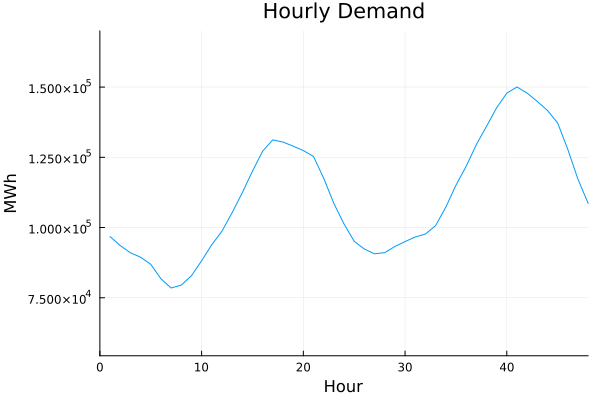

In [ ]:
plot(load.Load_MW_z1+load.Load_MW_z2+load.Load_MW_z3+load.Load_MW_z4+load.Load_MW_z5+load.Load_MW_z6, xlims=(0,48) ,label="")
title!("Hourly Demand")
xaxis!("Hour")
yaxis!("MWh")

#print(load.Load_MW_z1)